In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

This notebook explored the Colorado electric vehicle charging station dataset, which contains the energy use, length of charging time, gasoline savings and greenhouse gas emission reductions from all city-owned electric vehicle (EV) charging stations. Data are broken out by charging station name/location, transaction date, and transaction start time. Each row indicates one EV charging station transaction. A data dictionary with descriptions of the fields included in the dataset can be downloaded https://webappsprod.bouldercolorado.gov/opendata/ev_datadictionary.csv.

#### Load Data

In [2]:
df = pd.read_csv('Electric_Vehicle_Charging_Station_Data.csv')
df.head()

,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,Charging_Time__hh_mm_ss_,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,Port_Type,ObjectID,ObjectId2
0,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/1/2018 17:49,MDT,1/1/2018 19:52,MDT,2:03:02,2:02:44,6.504,2.732,0.816,Level 2,0,1
1,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 8:52,MDT,1/2/2018 9:16,MDT,0:24:34,0:24:19,2.481,1.042,0.311,Level 2,1,2
2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 21:11,MDT,1/3/2018 6:23,MDT,9:12:21,3:40:52,15.046,6.319,1.888,Level 2,2,3
3,BOULDER / ALPINE ST1,1275 Alpine Ave,Boulder,Colorado,80304,1/3/2018 9:19,MDT,1/3/2018 11:14,MDT,1:54:51,1:54:29,6.947,2.918,0.872,Level 2,3,4
4,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,1/3/2018 14:13,MDT,1/3/2018 14:30,MDT,0:16:58,0:16:44,1.800,0.756,0.226,Level 2,4,5


In [3]:
df.shape

(148136, 17)

In [4]:
# how many charge stations
df['Station_Name'].nunique()

50

#### Data Cleaning

In [5]:
# check null values
df.isnull().sum()
#df[df.isnull().any(axis=1)]

Station_Name                  0
Address                       0
City                          0
State_Province                0
Zip_Postal_Code               0
Start_Date___Time             0
Start_Time_Zone               0
End_Date___Time               4
End_Time_Zone                 0
Total_Duration__hh_mm_ss_     0
Charging_Time__hh_mm_ss_      0
Energy__kWh_                  0
GHG_Savings__kg_              0
Gasoline_Savings__gallons_    0
Port_Type                     0
ObjectID                      0
ObjectId2                     0
dtype: int64

In [6]:
# drop null values
df = df.dropna()

In [7]:
# standardize timestamp format
from dateutil import parser

# Function to parse timestamps
def parse_timestamp(timestamp):
    try:
        return parser.parse(str(timestamp))
    except ValueError:
        return None

# Apply the function to the timestamp column
df['Start_Date___Time'] = df['Start_Date___Time'].apply(parse_timestamp)
df['End_Date___Time'] = df['End_Date___Time'].apply(parse_timestamp)

# Format the parsed timestamps
df['Start_Date___Time'] = df['Start_Date___Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['End_Date___Time'] = df['End_Date___Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [8]:
# calculate charging time in hours
df['Charge_Time_hours'] = df['Charging_Time__hh_mm_ss_'] / np.timedelta64(1, 'h')

In [9]:
#calculate weekday of charging timestamp
df['Start_Date___Time'] = pd.to_datetime(df['Start_Date___Time'])
#df['Day_of_Week'] = df['Start_Date___Time'].dt.day_name()
df['Day_of_Week'] = df['Start_Date___Time'].dt.strftime('%a')

In [10]:
df['Charge_Time_hours'].describe()

count    148132.000000
mean          1.731388
std           1.691087
min           0.000000
25%           0.683056
50%           1.385278
75%           2.259167
max          50.400278
Name: Charge_Time_hours, dtype: float64

In [11]:
# remove outliers using the IQR method
def remove_outliers_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    # Calculate the IQR
    IQR = Q3 - Q1
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Remove outliers
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

# Apply the function to remove outliers
df = remove_outliers_iqr(df, 'Charge_Time_hours')

#### EDA

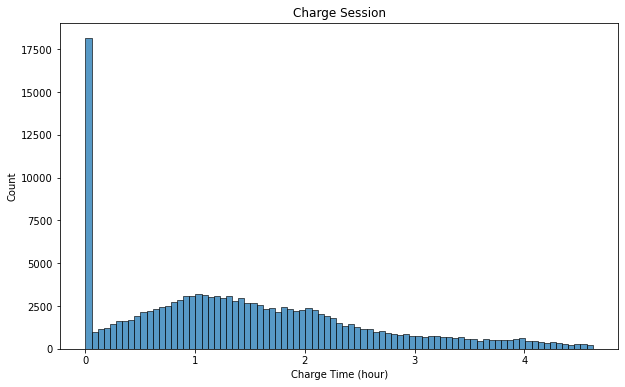

In [12]:
# charge time histagram
plt.figure(figsize=(10,6))
sns.histplot(data=df['Charge_Time_hours'])
plt.title("Charge Session")
plt.xlabel("Charge Time (hour)")
plt.show()

In [13]:
# total energy dispensed by charging station
df_station = df.groupby('Station_Name', as_index=False)['Energy__kWh_'].sum()

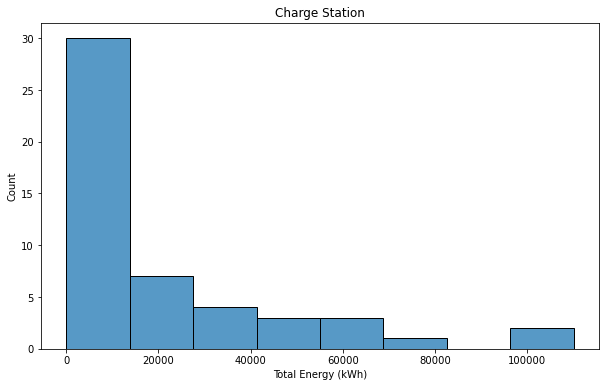

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(data=df_station['Energy__kWh_'])
plt.title("Charge Station")
plt.xlabel("Total Energy (kWh)")
plt.show()

In [15]:
# get station count and GHG Saving by zipcode
df_zipcode = df.groupby('Zip_Postal_Code', as_index=False) \
               .agg({'Station_Name':'nunique', 'GHG_Savings__kg_':'sum'}) \
               .rename(columns={'Station_Name': 'Station_Count', 'GHG_Savings__kg_': 'Total_GHG_Savings'})

In [16]:
df_zipcode

,Zip_Postal_Code,Station_Count,Total_GHG_Savings
0,80301,22,84707.603
1,80302,21,286826.613
2,80303,3,122052.662
3,80304,2,73835.056
4,80305,2,50542.214


#### Heatmap of GHG Saving

In [17]:
import geopandas as gpd
import folium

# Load the GeoJSON file with ZIP code boundaries
geojson_path = 'co_zip_codes.json'
zip_geo = gpd.read_file(geojson_path)

# Ensure ZIP codes are strings for merging
df_zipcode['Zip_Postal_Code'] = df_zipcode['Zip_Postal_Code'].astype(str)
zip_geo['ZCTA5CE10'] = zip_geo['ZCTA5CE10'].astype(str)

# Merge the DataFrame with the GeoDataFrame
merged = zip_geo.set_index('ZCTA5CE10').join(df_zipcode.set_index('Zip_Postal_Code'))
merged = merged.dropna()

# Create a base map
m = folium.Map(location=[40.018578, -105.271499], zoom_start=11)

# Add the choropleth layer
folium.Choropleth(
    geo_data=merged,
    name='choropleth',
    data=merged,
    columns=[merged.index, 'Total_GHG_Savings'],
    key_on='feature.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='GHG_Savings_kg'
).add_to(m)

# Add a layer control panel to the map
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('GHG_Saving_Heatmap.html')